# Objective
* Predict stock price in next day using linear regression
* Given prices for the last N days, we train a model, and predict for day N+1

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader as pdr
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################

cv_size = 0.35  # proportion of dataset to be used as cross-validation set
               # choose data after 2020-01-01 as test set
Nmax = 30  # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
           # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

####################################

/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Common functions

In [2]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.arange(len(df['adj_close'][i-N:i])) # e.g. [0 1 2 3 4]
        y_train = np.array(df['adj_close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
#         print(X_train.shape)
#         print(y_train.shape)
#         print('X_train = \n' + str(X_train))
#         print('y_train = \n' + str(y_train))
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict([[N]])
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
# df = pd.read_csv(stk_path, sep = ",")
df = pdr.get_data_yahoo('^GSPC',start = '2015-02-28', end = '2020-02-28')
df = df.reset_index()
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.tail(50)

,date,high,low,open,close,volume,adj_close,month
1209,2019-12-17,3198.219971,3191.030029,3195.399902,3192.520020,3837540000,3192.520020,12
1210,2019-12-18,3198.479980,3191.139893,3195.209961,3191.139893,4014080000,3191.139893,12
1211,2019-12-19,3205.479980,3192.320068,3192.320068,3205.370117,3720450000,3205.370117,12
1212,2019-12-20,3225.649902,3216.030029,3223.330078,3221.219971,6454270000,3221.219971,12
1213,2019-12-23,3227.780029,3222.300049,3226.050049,3224.010010,3060610000,3224.010010,12
1214,2019-12-24,3226.429932,3220.510010,3225.449951,3223.379883,1296540000,3223.379883,12
1215,2019-12-26,3240.080078,3227.199951,3227.199951,3239.909912,2160680000,3239.909912,12
1216,2019-12-27,3247.929932,3234.370117,3247.229980,3240.020020,2428670000,3240.020020,12
1217,2019-12-30,3240.919922,3216.570068,3240.090088,3221.290039,3013290000,3221.290039,12
1218,2019-12-31,3231.719971,3212.030029,3215.179932,3230.780029,2893810000,3230.780029,12


In [4]:
# dt = pdr.get_data_yahoo('^GSPC',start = '2015-04-30', end = '2020-04-30')
# dt.reset_index()

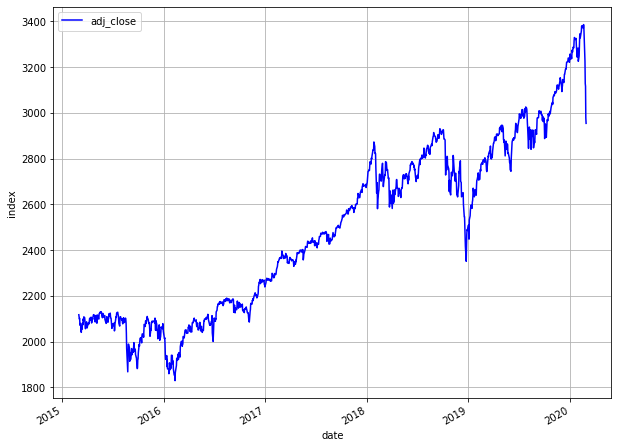

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("index")
plt.show()

# Split into train, dev and test set

In [6]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = 104 # Choose data after 2019-10-01
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 715
num_cv = 440
num_test = 104
train.shape = (715, 8)
cv.shape = (440, 8)
train_cv.shape = (1155, 8)
test.shape = (104, 8)


In [7]:
cv

,date,high,low,open,close,volume,adj_close,month
715,2017-12-29,2692.120117,2673.610107,2689.149902,2673.610107,2443490000,2673.610107,12
716,2018-01-02,2695.889893,2682.360107,2683.729980,2695.810059,3367250000,2695.810059,1
717,2018-01-03,2714.370117,2697.770020,2697.850098,2713.060059,3538660000,2713.060059,1
718,2018-01-04,2729.290039,2719.070068,2719.310059,2723.989990,3695260000,2723.989990,1
719,2018-01-05,2743.449951,2727.919922,2731.330078,2743.149902,3236620000,2743.149902,1
...,...,...,...,...,...,...,...,...
1150,2019-09-24,3007.979980,2957.729980,3002.429932,2966.600098,3868160000,2966.600098,9
1151,2019-09-25,2989.820068,2952.860107,2968.350098,2984.870117,3318870000,2984.870117,9
1152,2019-09-26,2987.280029,2963.709961,2985.729980,2977.620117,3077240000,2977.620117,9
1153,2019-09-27,2987.310059,2945.530029,2985.469971,2961.790039,3243650000,2961.790039,9


# EDA

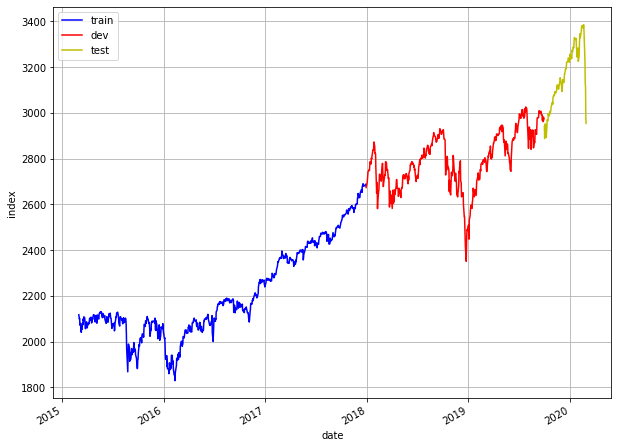

In [8]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='r-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("index")
plt.show()

# Predict using Linear Regression

In [9]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv['est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

RMSE = [26.669045594674337, 38.20572468441327, 33.906357538852625, 32.09159442984644, 32.37885803471349, 33.59662353633047, 34.92501360338979, 35.76346959302971, 37.03670223479143, 38.154039795639385, 39.213194970138886, 40.34136466105603, 41.43441192702637, 42.518734379455815, 43.76634052701953, 45.079047027881685, 46.23320229547561, 47.15978158447339, 47.89855740404829, 48.56381988588572, 49.30101133697131, 50.05466127868458, 50.81294558730534, 51.56312998943309, 52.383087021754456, 53.24470543867988, 54.077390990352065, 54.90672494152857, 55.669977505738395, 56.42096991884778]
R2 = [0.9518757565781896, 0.9012343671897759, 0.9222122442751342, 0.9303162430780995, 0.9290631299165468, 0.9236269327142502, 0.9174680445595345, 0.9134577349630187, 0.90718597922869, 0.9015014076903016, 0.895956866245006, 0.8898840733385173, 0.8838360621413284, 0.8776765772469378, 0.8703927077900641, 0.8625013544561726, 0.8553704889365181, 0.8495152340266923, 0.8447635028735382, 0.8404214014897944, 0.83553987

/Users/yongyizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,high,low,open,close,volume,adj_close,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
715,2017-12-29,2692.120117,2673.610107,2689.149902,2673.610107,2443490000,2673.610107,12,2687.540039,2692.459961,...,2696.092613,2696.040299,2697.951984,2699.118895,2700.207847,2700.665306,2702.017858,2703.098615,2703.258672,2704.528686
716,2018-01-02,2695.889893,2682.360107,2683.729980,2695.810059,3367250000,2695.810059,1,2673.610107,2659.680176,...,2694.585299,2695.169795,2695.297483,2697.292052,2698.574565,2699.778612,2700.370682,2701.818078,2703.001508,2703.291808
717,2018-01-03,2714.370117,2697.770020,2697.850098,2713.060059,3538660000,2713.060059,1,2695.810059,2718.010010,...,2698.983262,2697.630064,2698.179465,2698.297193,2700.208562,2701.450868,2702.626072,2703.217994,2704.637947,2705.809551
718,2018-01-04,2729.290039,2719.070068,2719.310059,2723.989990,3695260000,2723.989990,1,2713.060059,2730.310059,...,2705.390881,2704.555788,2703.150145,2703.564842,2703.578657,2705.325664,2706.448730,2707.520539,2708.040651,2709.368021
719,2018-01-05,2743.449951,2727.919922,2731.330078,2743.149902,3236620000,2743.149902,1,2723.989990,2734.919922,...,2712.563910,2712.061489,2711.115675,2709.627773,2709.886951,2709.774541,2711.340540,2712.324744,2713.273183,2713.700237


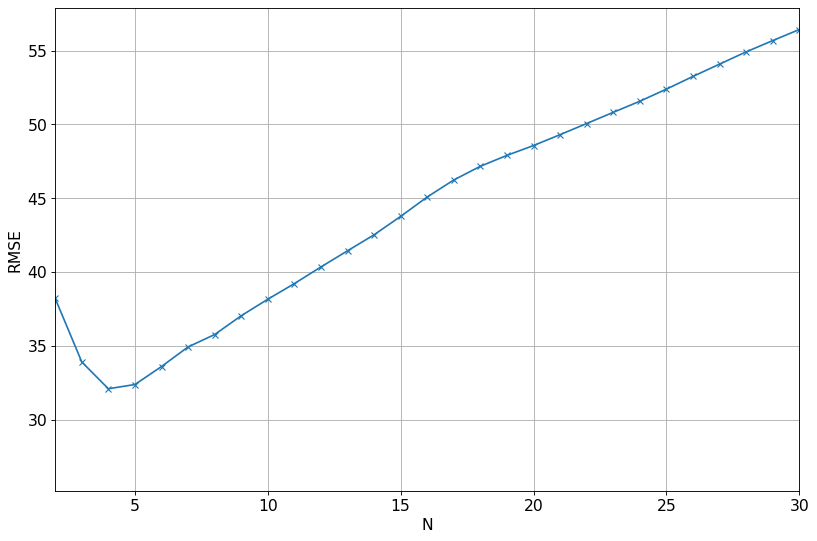

In [10]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])
plt.show()

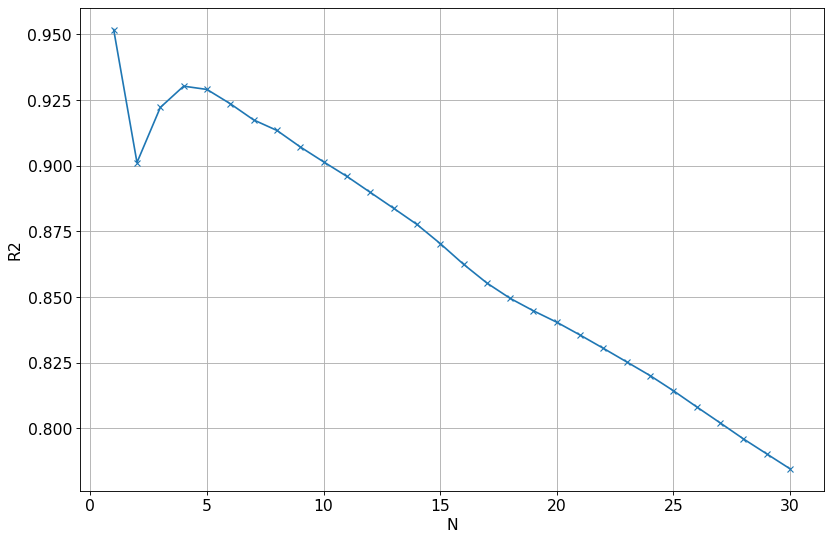

In [11]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')
plt.show()

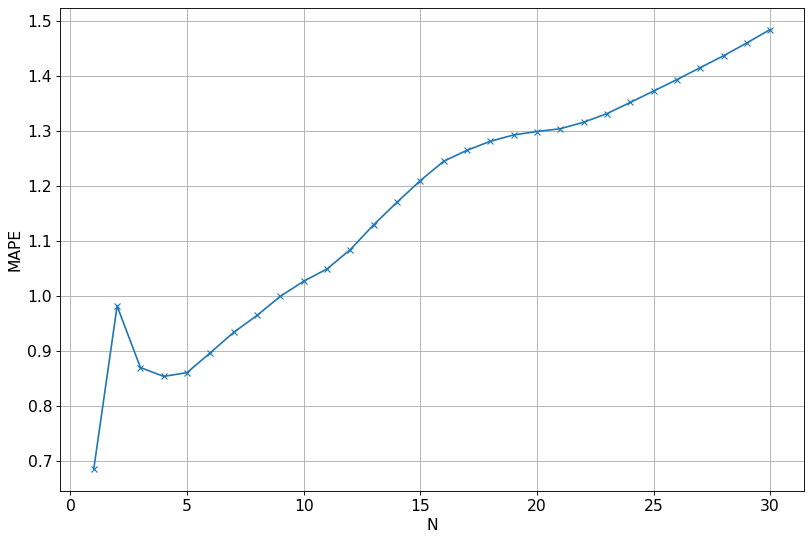

In [12]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.show()

Roughly the optimum N is 4. The lowest RMSE, MAPE and the highest R2 are achieved with N=1, followed by N=4. 

In [13]:
# Set optimum N
N_opt = 4

# Plot predictions for a specific day. For checking

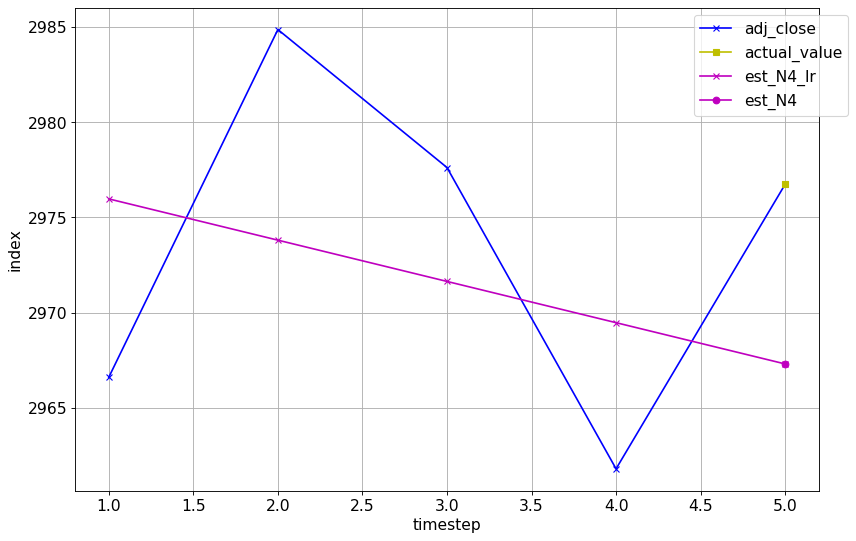

In [14]:
# Specify the day you are interested in
day = pd.Timestamp(date(2019, 10, 31))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 4

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(4, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('index')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# Plot predictions on dev set

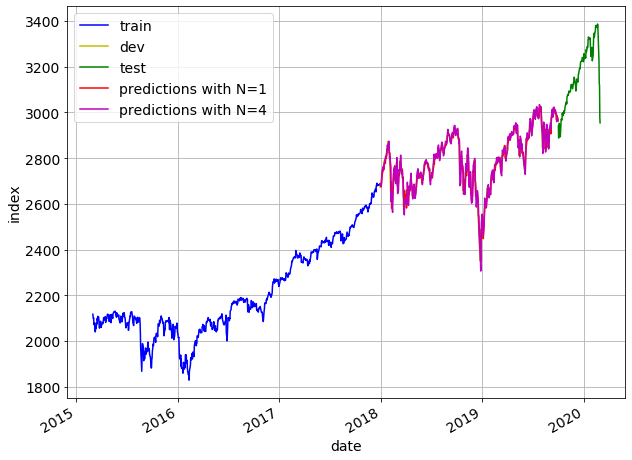

In [15]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N4', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("index")
plt.show()

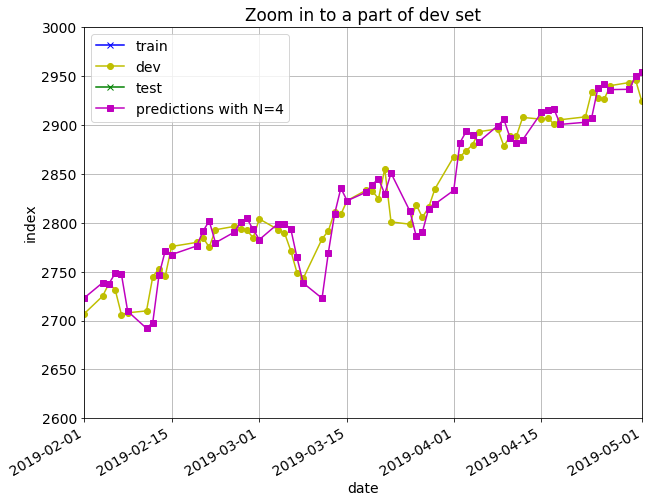

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yo-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
# ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N4', style='ms-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("index")
ax.set_xlim([date(2019, 2, 1), date(2019, 5, 1)])
ax.set_ylim([2600, 3000])
ax.set_title('Zoom in to a part of dev set')
plt.show()

# Final model

In [17]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test['est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 30.394
R2 = 0.948
MAPE = 0.701%


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,high,low,open,close,volume,adj_close,month,est_N4
1155,2019-10-01,2992.530029,2938.699951,2983.689941,2940.250000,3558040000,2940.250000,10,2965.199951
1156,2019-10-02,2924.780029,2874.929932,2924.780029,2887.610107,3912520000,2887.610107,10,2939.809937
1157,2019-10-03,2911.129883,2855.939941,2885.379883,2910.629883,3503640000,2910.629883,10,2876.840088
1158,2019-10-04,2953.739990,2918.560059,2918.560059,2952.010010,2990830000,2952.010010,10,2866.064941
1159,2019-10-07,2959.750000,2935.679932,2944.229980,2938.790039,2940140000,2938.790039,10,2937.199951


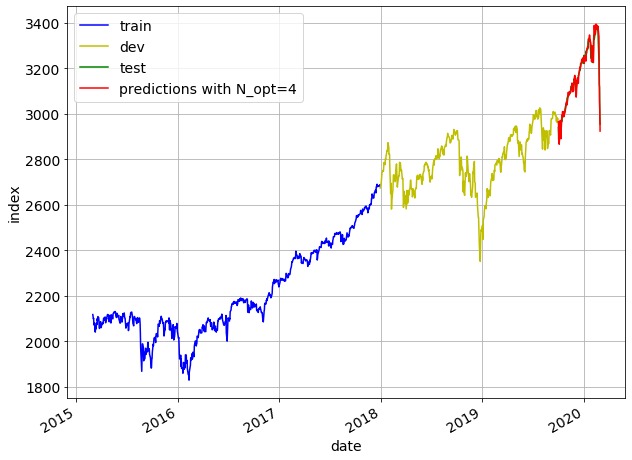

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("index")
plt.show()

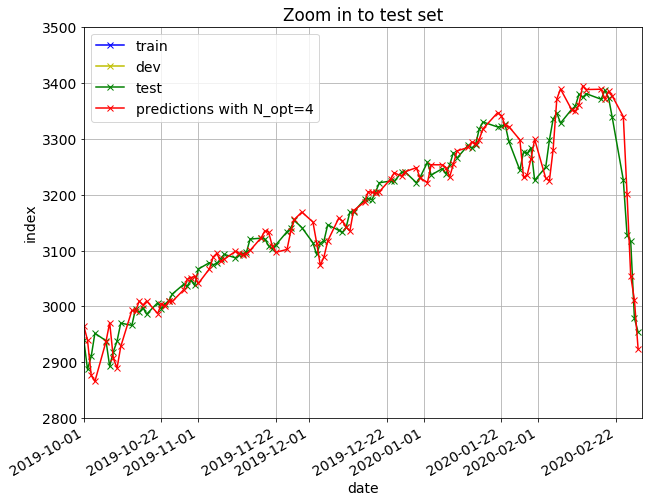

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'], loc = 2)
ax.set_xlabel("date")
ax.set_ylabel("index")
ax.set_xlim([date(2019, 10, 1), date(2020, 2, 29)])
ax.set_ylim([2800, 3500])
ax.set_title('Zoom in to test set')
plt.show()

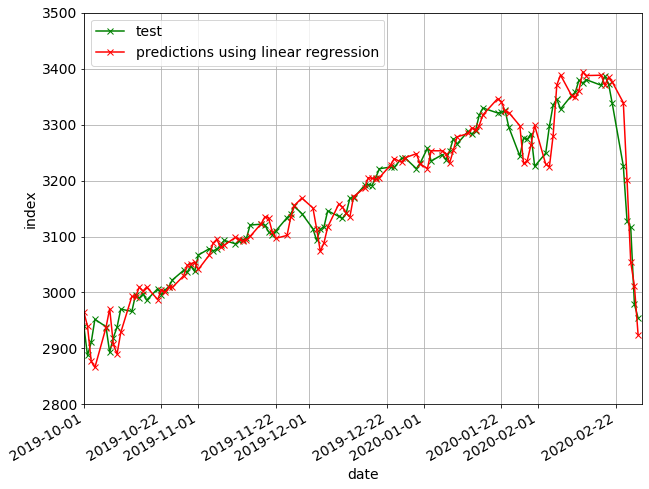

In [20]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc=2)
ax.set_xlabel("date")
ax.set_ylabel("index")
ax.set_xlim([date(2019, 10, 1), date(2020, 2, 29)])
ax.set_ylim([2800, 3500])
plt.show()

# Trading Strategy

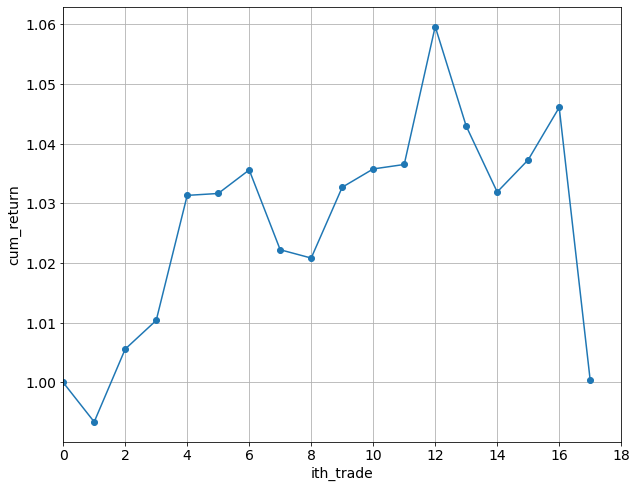

win rate: 0.6470588235294118


In [21]:
# using the prediction, suppose we buy when the algorithm predict that the price will rise, sell when it fall
dtrad = test
dtrad = dtrad.reset_index(drop=True)

win, count, hold, btemp, stemp = [0 for i in range(5)]
cum = np.array([1])

for i in range(len(dtrad)-1):
    if dtrad["est_N4"][i+1]>dtrad["adj_close"][i] and hold==0:
        hold = 1
        btemp = dtrad["adj_close"][i]
    if dtrad["est_N4"][i+1]<dtrad["adj_close"][i] and hold==1:
        hold = 0
        stemp = dtrad["adj_close"][i]
        p = (stemp - btemp) / btemp
        cum = np.append(cum, cum[-1] * (1 + p))
        count += 1
        if p>0:
            win += 1
sdate = np.arange(len(cum))
plt.plot(sdate, cum, 'o-')
plt.xlabel("ith_trade")
plt.ylabel("cum_return")
plt.xlim([0, 18])
plt.grid()
plt.show()
print("win rate:", win/count)

In [22]:
# Save as csv
test_lin_reg = test
test_lin_reg.to_csv("test_lin_reg.csv")